In [1]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

from scipy.stats import entropy
from tqdm.notebook import tqdm

### Создаем истинные семейства по базе данных Norine

In [2]:
data = pd.read_csv('norineText.csv', sep=';', dtype='string')

In [3]:
families = {}

for i in range(len(data)):
    pep_id, family = data['id_peptide'][i], data['family'][i]
    pep_id = int(pep_id[3:])
    if families.get(family) == None:
        families[family] = [pep_id]
    else:
        families[family].append(pep_id)

In [4]:
families.pop('unknown', None)
families.pop('other', None)
families.pop('none', None)
families

{'daptomycin': [1, 757, 758, 759],
 'A54145': [2, 3, 4, 5, 714, 715, 716, 717],
 'ACV': [6],
 'alamethicin': [7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17],
 'bacitracin': [18,
  19,
  20,
  21,
  22,
  913,
  914,
  915,
  916,
  917,
  918,
  919,
  920,
  921,
  922,
  923],
 'Calcium dependent antibiotic': [23, 24, 25, 26, 27, 28, 29, 30, 31, 32],
 'cyclosporin': [33,
  34,
  35,
  36,
  37,
  38,
  39,
  40,
  41,
  42,
  43,
  44,
  45,
  46,
  47,
  48,
  49,
  50,
  51,
  52,
  53,
  54,
  55,
  56,
  57,
  58,
  59,
  60,
  61,
  62,
  63],
 'destruxin': [64,
  65,
  66,
  67,
  68,
  69,
  70,
  71,
  72,
  73,
  74,
  75,
  76,
  77,
  78,
  79,
  80,
  81,
  82,
  83,
  84,
  85,
  86,
  87,
  88,
  89,
  90,
  91,
  760,
  761,
  1271],
 'enniatin': [92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 104, 105],
 'microcystin': [106,
  107,
  108,
  109,
  110,
  111,
  112,
  113,
  114,
  115,
  116,
  117,
  118,
  119,
  120,
  121,
  122,
  123,
  124,
  125,
  126,
  127,
  12

In [5]:
print('families with greater then 20 pnps:')
for name, ids in families.items():
    if len(ids) > 20:
        print(name)
print()
print('families with only 1 pnp:')
for name, ids in families.items():
    if len(ids) == 1:
        print(name)

families with greater then 20 pnps:
cyclosporin
destruxin
microcystin
pyoverdin
surfactin
iturin
beauverolide
hypomurocin
cyclic depsipeptide

families with only 1 pnp:
ACV
bacilysin
chrysobactin
vibriobactin
enterobactin
anguibactin
brevianamide
HC-toxin
jaspamide
bacillibactin
micromide
aeruginosin
callynormine
corrugatin
cyclonellin
gymnangiamide
obyanamide
nagahamide
cyclolithistide
microspinosamide
tokaramide
leupeptin
miraziridine
nazumamide
pallidin
hymenistatin
stylostatin
wainunuamide
cyclolinopeptide
theonegramide
theopalauamide
perthamide
cupolamide
waiakeamide
ceratospongamide
konbamide
orbiculamide
oriamide
neosiphoniamolide
majusculamide
foroxymithine
chlamydocin
tentoxin
bottromycin
kulokainalide
pupukeamide
empedopeptin
lysobactin
cereulide
gratisin
valinomycin
montanastatin
mycobacillin
antipain
phosphinothricin tripeptide
virginiamycin
BT antibiotic
vancomycin
A42867
A51568
A83850
decaplanin
eremomycin
OA7653
corticiamide
boletusin
heptaibin
peptaibolin
feglymycin
eno

In [6]:
for name, ids in families.items():
    if name[-2:] != 'in' and name[-3:] != 'ide' and name[-3:] != 'ine':
        print(name)

A54145
ACV
Calcium dependent antibiotic
ferintoic acid
PF1022
andrimid
pristinamycin I
BT antibiotic
A42867
A51568
A83850
M43
MM
OA7653
cephaibol
LP237
nrp siderophore
beta-lactam


In [7]:
# with open('families.txt', 'w') as f:
#     for name, ids in families.items():
#         f.write(' '.join([str(i) for i in ids]) + '\n')

### Редактируем спектры перед обработкой GNPS

In [8]:
# undef_pep = 0

# with open('lib.info.norine') as lib:
#     with open('norine_spectrums.mgf') as specs:
#         with open('norine_spectrums_complete.mgf', 'w') as specs_comp:
#             for line in specs.readlines():
#                 if line == 'TITLE=\n':
#                     pep_name = lib.readline().split()[1].replace('_', ' ')
#                     if len(data[data['name'] == pep_name]) == 0:
#                         print(pep_name)
#                         undef_pep += 1
#                         pep_id = -undef_pep
#                     else:
#                         pep_id = int(data[data['name'] == pep_name].reset_index()['id_peptide'][0][-5:])
#                     specs_comp.write('TITLE=' + pep_name + '\n')
#                     specs_comp.write('SCANS=' + str(pep_id) + '\n')
#                 else:
#                     specs_comp.write(line)

### Поиск оптимальных параметров кластеризации, обработка low cos norine clusterisation

In [9]:
path = 'clustered_spectra_low_cos/'

In [10]:
info = pd.read_csv(path + 'norine.clusterinfo', sep='\t')[['#ClusterIdx', '#Scan', '#ParentMass']]
info.index = info['#ClusterIdx']
info.index.name = 'CLUSTERID'
info = info[['#Scan', '#ParentMass']]
info

,#Scan,#ParentMass
CLUSTERID,,
1,1,1620.720
2,6,364.154
3,7,1963.140
4,10,1964.120
5,18,1422.760
...,...,...
934,1947,1497.540
935,1948,275.208
936,1956,672.310


In [11]:
edges = pd.read_csv(path + 'norine.selfloop', sep='\t')[['CLUSTERID1', 'CLUSTERID2', 'DeltaMZ', 'Cosine', 'ComponentIndex', 'EdgeAnnotation']]
edges = edges[edges.ComponentIndex != -1]
# edges = edges[edges.Cosine >= 0.73]
edges

,CLUSTERID1,CLUSTERID2,DeltaMZ,Cosine,ComponentIndex,EdgeAnnotation
0,116,348,-67.042,0.6667,1,C4H5N
1,109,111,34.968,1.0000,1,
2,718,719,15.995,0.9129,1,O
3,110,121,-31.972,1.0000,1,
4,111,116,15.011,1.0000,1,secondary amine:NH
...,...,...,...,...,...,...
2376,478,479,2.016,0.5164,95,H2
2377,202,478,-18.011,0.5164,95,H2O
2378,73,519,-2.016,1.0000,96,H2
2379,504,505,-56.060,0.9722,97,C3H6N:C4H8


In [12]:
edges.describe()

,CLUSTERID1,CLUSTERID2,DeltaMZ,Cosine,ComponentIndex
count,2381.000000,2381.000000,2381.000000,2381.000000,2381.000000
mean,357.222176,509.603108,-8.127425,0.778128,17.640487
std,290.814259,302.836078,115.464302,0.179203,19.140417
min,1.000000,4.000000,-790.430000,0.500000,1.000000
25%,77.000000,204.000000,-42.022000,0.590900,7.000000
50%,300.000000,560.000000,-2.015000,0.774600,13.000000
75%,588.000000,801.000000,28.032000,0.987400,19.000000
max,936.000000,938.000000,790.435000,1.000000,98.000000


In [13]:
summary = pd.read_csv(path + 'norine.clustersummary', sep='\t')[['cluster index', 'componentindex', 'parent mass']]
summary

,cluster index,componentindex,parent mass
0,1,6,1620.720
1,2,-1,364.154
2,3,30,1963.140
3,4,30,1964.120
4,5,17,1422.760
...,...,...,...
933,934,43,1497.540
934,935,-1,275.208
935,936,56,672.310
936,937,56,690.321


In [14]:
GNPS = nx.Graph()

for _, row in edges.iterrows():
    v1, v2, delta, cos, CI, note = row
    id1, id2 = info.loc[[v1, v2], '#Scan']
    GNPS.add_edge(id1, id2, DeltaMZ=delta, Cosine=cos, ComponentIndex=CI, EdgeAnnotation=note)

GNPS.remove_node(-2)
print(GNPS.number_of_nodes(), GNPS.number_of_edges())

665 2379


In [15]:
nrps_with_spectra = nx.Graph()

for family, ids in families.items():
    nrps_with_spectra = nx.union(nrps_with_spectra, nx.complete_graph(ids))

In [16]:
nrps_with_spectra = nrps_with_spectra.subgraph(list(GNPS.nodes())).copy()
print(nrps_with_spectra.number_of_nodes(), nrps_with_spectra.number_of_edges())

G = GNPS.subgraph(list(nrps_with_spectra.nodes())).copy()
print(G.number_of_nodes(), G.number_of_edges())

542 1953
542 1589


In [17]:
def ccs(graph):
    return sorted([sorted(list(_)) for _ in nx.connected_components(graph)])

In [18]:
G_ccs = ccs(G)
G_ccs

[[1],
 [7, 10, 1023],
 [18, 20, 21, 913, 916, 923],
 [28, 29],
 [33,
  34,
  35,
  36,
  37,
  38,
  39,
  40,
  41,
  43,
  497,
  498,
  499,
  500,
  501,
  561,
  562,
  563,
  564],
 [64,
  65,
  66,
  67,
  68,
  71,
  73,
  74,
  75,
  76,
  77,
  78,
  79,
  80,
  81,
  85,
  86,
  87,
  90,
  91,
  106,
  107,
  108,
  109,
  110,
  111,
  112,
  113,
  116,
  117,
  121,
  125,
  128,
  137,
  138,
  139,
  140,
  148,
  154,
  155,
  159,
  228,
  230,
  231,
  232,
  233,
  234,
  235,
  236,
  237,
  239,
  241,
  242,
  249,
  279,
  298,
  299,
  300,
  301,
  308,
  309,
  310,
  311,
  313,
  314,
  316,
  317,
  319,
  322,
  323,
  326,
  392,
  427,
  428,
  429,
  452,
  453,
  454,
  455,
  481,
  482,
  483,
  515,
  516,
  517,
  518,
  519,
  520,
  521,
  522,
  523,
  524,
  525,
  526,
  529,
  530,
  531,
  532,
  533,
  534,
  535,
  538,
  539,
  542,
  544,
  547,
  550,
  560,
  648,
  657,
  773,
  774,
  775,
  817,
  824,
  825,
  1142,
  1143,
  115

In [19]:
nws_ccs = ccs(nrps_with_spectra)
nws_ccs

[[1],
 [7, 10],
 [18, 20, 21, 913, 916, 923],
 [28, 29],
 [33, 34, 35, 36, 37, 38, 39, 40, 41, 43],
 [64,
  65,
  66,
  67,
  68,
  71,
  73,
  74,
  75,
  76,
  77,
  78,
  79,
  80,
  81,
  85,
  86,
  87,
  90,
  91,
  1271],
 [92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 105],
 [106,
  107,
  108,
  109,
  110,
  111,
  112,
  113,
  116,
  117,
  121,
  125,
  128,
  137,
  138,
  139,
  140,
  148,
  154,
  155,
  159,
  817],
 [160, 903],
 [211, 856],
 [220, 221, 222, 224],
 [226, 1265],
 [228, 230, 231, 232, 233, 234, 235, 236, 237, 239, 241, 242],
 [243, 245, 249],
 [252, 253, 254, 255, 256, 712, 713],
 [257, 258, 259, 260],
 [261, 262, 263, 264, 266, 267, 269, 270, 271],
 [272],
 [274, 275],
 [276, 277, 278],
 [279, 824, 825],
 [281, 282, 283, 284, 285, 286, 287],
 [296, 766, 767, 768],
 [298, 299, 300, 301],
 [304],
 [305, 306, 307],
 [308, 309, 310, 311, 313, 314, 316, 317, 319, 322, 323, 326],
 [329],
 [331, 332, 333, 334, 335, 336, 338, 882, 883, 884, 885, 886],
 [339, 

In [20]:
# with open('families_with_spectra.txt', 'w') as f:
#     for cc in nws_ccs:
#         f.write(' '.join([str(i) for i in cc])+'\n')

#### Поиск оптимального Cosine threshold

In [21]:
size = len(G.nodes())
measures_num = 5

def measures(t):
    H = nx.Graph()
    H.add_nodes_from(G.nodes())
    for e in G.edges():
        if G.edges[e]['Cosine'] >= t:
            H.add_edge(*e)
    H_ccs = ccs(H)
    
    p = np.array([[len(set(cc1) & set(cc2)) for cc2 in H_ccs] for cc1 in nws_ccs]) / size
    a = np.sum(p, axis = 1)
    b = np.sum(p, axis = 0)
    
    # Purity, more the better
    Purity = 0.5 * (np.sum(np.amax(p, axis=1)) + np.sum(np.max(p, axis=0)))
    
    # F-measure, more the better
    F_measure = 0
    for j in range(len(b)):
        F_measure += 2 * b[j] * np.amax(p[:, j] / (a + b[j]))
    
    # Entropy, less the better
    entropy_H = np.sum(a * entropy(p, axis=1))
    entropy_nws = np.sum(b * entropy(p, axis=0))
    sum_entropy = entropy_H + entropy_nws
    
    return Purity, F_measure, entropy_H, entropy_nws, sum_entropy


In [22]:
t = np.arange(0.6, 0.9, 0.0005)
meas = np.zeros((t.shape[0], measures_num))
for i in tqdm(range(t.shape[0])):
    meas[i, :] = measures(t[i])

  0%|          | 0/601 [00:00<?, ?it/s]

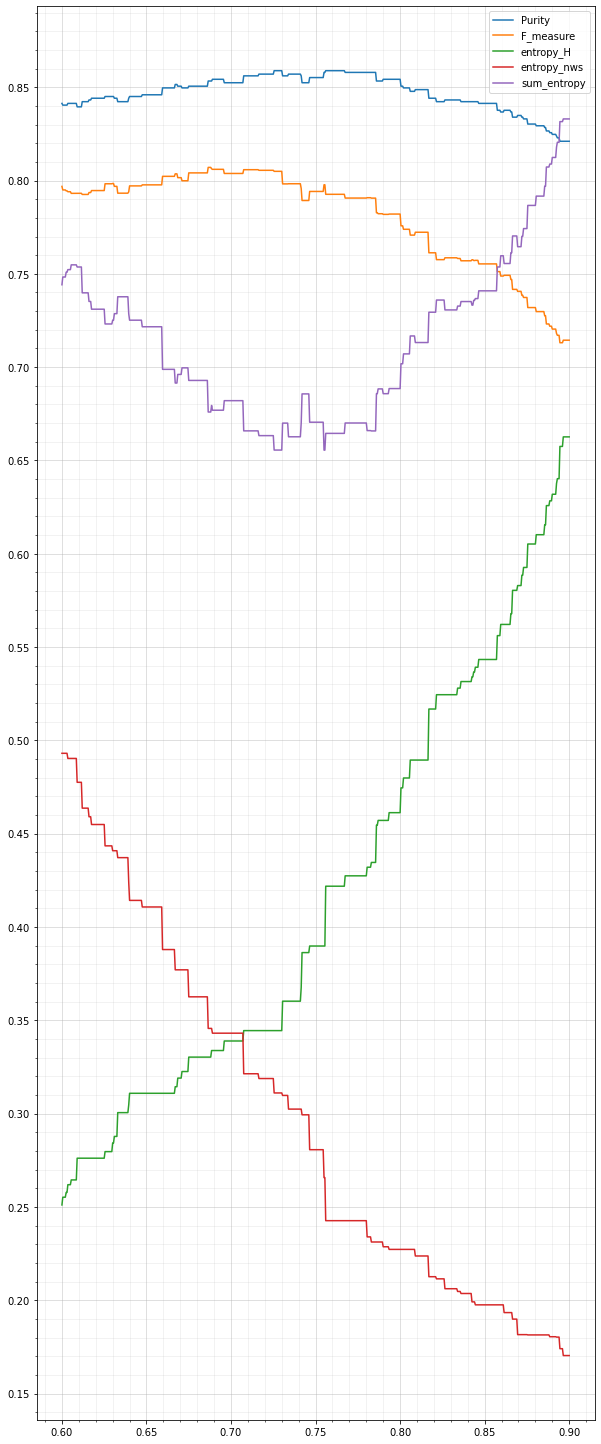

In [23]:
labels = ['Purity', 'F_measure', 'entropy_H', 'entropy_nws', 'sum_entropy']

fig = plt.figure(figsize=(10, 26))
ax = fig.add_subplot()
xmajor_ticks = np.arange(0.5, 1.0, 0.05)
xminor_ticks = np.arange(0.5, 1.0, 0.01)
ymajor_ticks = np.arange(0, 1.3, 0.05)
yminor_ticks = np.arange(0, 1.3, 0.01)

ax.set_xticks(xmajor_ticks)
ax.set_xticks(xminor_ticks, minor=True)
ax.set_yticks(ymajor_ticks)
ax.set_yticks(yminor_ticks, minor=True)
ax.grid(which='minor', alpha=0.2)
ax.grid(which='major', alpha=0.5)

for i in range(measures_num):
    plt.plot(t, meas[:, i], label=labels[i])
plt.legend()
plt.show()

In [24]:
threshold = 0.73

In [25]:
GNPS_filtered = nx.Graph()
GNPS_filtered.add_nodes_from(GNPS.nodes())
for e in GNPS.edges():
    if GNPS.edges[e]['Cosine'] >= threshold:
        GNPS_filtered.add_edge(*e)
print(GNPS_filtered.number_of_nodes(), GNPS_filtered.number_of_edges())

665 1326


In [26]:
GNPS_filtered_ccs = ccs(GNPS_filtered)
GNPS_filtered_ccs

[[1, 1919],
 [7, 10],
 [18, 20, 21, 913, 916, 923],
 [28, 29, 1947],
 [33,
  34,
  35,
  36,
  37,
  38,
  39,
  40,
  41,
  43,
  1676,
  1690,
  1704,
  1724,
  1744,
  1751,
  1763,
  1773,
  1780,
  1805,
  1824],
 [64,
  65,
  66,
  67,
  68,
  71,
  73,
  74,
  75,
  77,
  78,
  79,
  80,
  81,
  85,
  86,
  87,
  90,
  91,
  1271,
  1615],
 [76],
 [92,
  93,
  94,
  95,
  96,
  97,
  98,
  99,
  100,
  101,
  102,
  105,
  252,
  253,
  254,
  255,
  256,
  437,
  712,
  713],
 [106,
  107,
  108,
  109,
  110,
  111,
  112,
  113,
  116,
  117,
  121,
  125,
  128,
  137,
  138,
  139,
  140,
  148,
  154,
  155,
  159,
  817,
  1547],
 [160, 903],
 [211, 856],
 [220, 221],
 [222],
 [224, 1490],
 [226, 1265],
 [228,
  230,
  231,
  232,
  233,
  234,
  235,
  236,
  237,
  239,
  241,
  242,
  1669,
  1801,
  1818],
 [243, 245, 1777, 1786],
 [249],
 [257, 258, 259, 260],
 [261, 262, 263, 264, 266, 267, 269, 270, 271, 272, 276, 277, 278, 1368],
 [274, 275],
 [279, 824, 825],
 [2

In [27]:
# with open('GNPS_clusters.txt', 'w') as f:
#     for cc in GNPS_filtered_ccs:
#         f.write(' '.join([str(i) for i in cc])+'\n')

In [28]:
# GNPS_with_spectra_filtered = nx.Graph()
# GNPS_with_spectra_filtered.add_nodes_from(G.nodes())
# for e in G.edges():
#     if G.edges[e]['Cosine'] >= threshold:
#         GNPS_with_spectra_filtered.add_edge(*e)
# print(GNPS_with_spectra_filtered.number_of_nodes(), GNPS_with_spectra_filtered.number_of_edges())

In [29]:
# GNPS_with_spectra_filtered_ccs = ccs(GNPS_with_spectra_filtered)
# GNPS_with_spectra_filtered_ccs

In [30]:
# with open('GNPS_with_spectra_clusters.txt', 'w') as f:
#     for cc in GNPS_with_spectra_filtered_ccs:
#         f.write(' '.join([str(i) for i in cc])+'\n')

In [31]:
# GNPS_default = nx.Graph()
# GNPS_default.add_nodes_from(G.nodes())
# for e in G.edges():
#     if G.edges[e]['Cosine'] >= 0.7:
#         GNPS_default.add_edge(*e)
# print(GNPS_default.number_of_nodes(), GNPS_default.number_of_edges())

In [32]:
# GNPS_default_ccs = ccs(GNPS_default)
# GNPS_default_ccs

In [33]:
# with open('GNPS_default_clusters.txt', 'w') as f:
#     for cc in GNPS_default_ccs:
#         f.write(' '.join([str(i) for i in cc])+'\n')